In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import ast

# Load data
df = pd.read_csv(r'C:\Apple_leaf\Object_Detection.csv')
images, bboxes = [], []

# Load images and bounding boxes
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    if img_array.size == 100 * 100 * 3:
        img_array = img_array.reshape(100, 100, 3)
        images.append(img_array)
        bboxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
    else:
        print(f"Skipping index {index}: Image size is {img_array.size}, expected {100 * 100 * 3}")

# Convert images and bounding boxes to NumPy arrays
images = np.array(images).reshape(-1, 100, 100, 3)
bboxes = np.array(bboxes, dtype=np.float32)

# Train-test split
X_train, X_test, bbox_train, bbox_test = train_test_split(
    images, bboxes, test_size=0.2, random_state=42
)

# Define RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    return tf.keras.Model(inputs=input_layer, outputs=x, name="RCNN_Model")

# Define DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False))(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    return tf.keras.Model(inputs=input_layer, outputs=x, name="DCN_Model")

# Combine RCNN and DCN Models for Bounding Box Prediction
def build_combined_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    rcnn_model = build_rcnn_model(input_shape)
    rcnn_features = rcnn_model(input_layer)
    dcn_model = build_dcn_model(input_shape)
    dcn_features = dcn_model(input_layer)
    combined_features = tf.keras.layers.Concatenate()([rcnn_features, dcn_features])
    bbox_output = tf.keras.layers.Dense(4, activation='linear', name='bbox_regression')(combined_features)
    model = tf.keras.Model(inputs=input_layer, outputs=bbox_output, name="Combined_RCNN_DCN_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error'
    )
    return model

# Train the model
model = build_combined_model()
history = model.fit(
    X_train, bbox_train,
    validation_data=(X_test, bbox_test),
    epochs=25,
    batch_size=32
)


13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


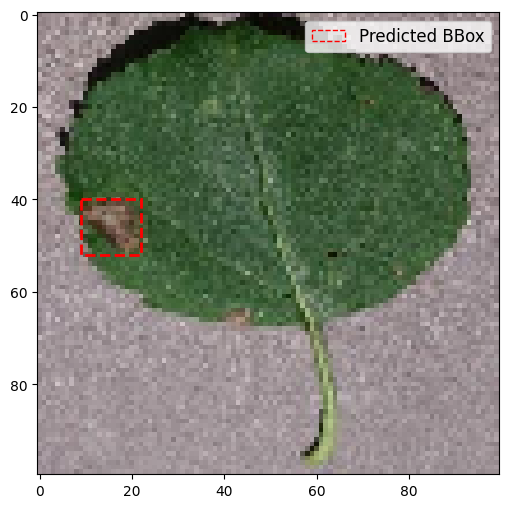

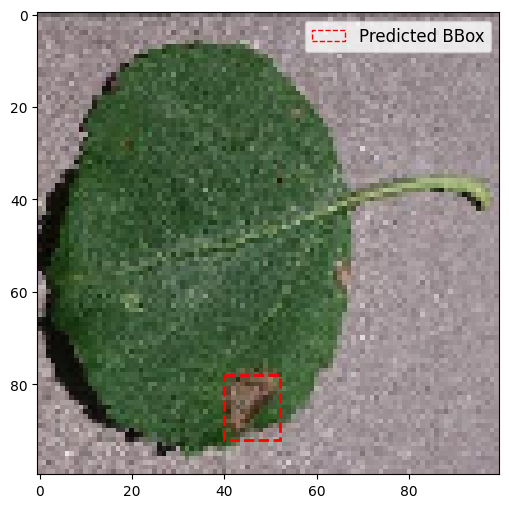

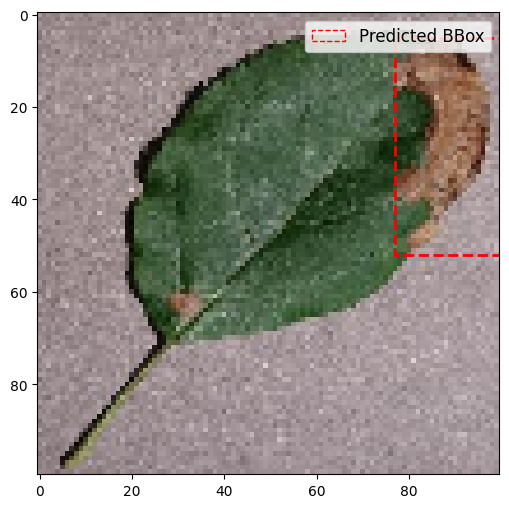

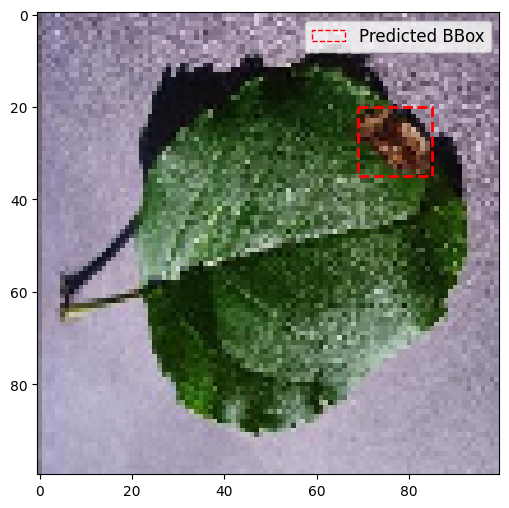

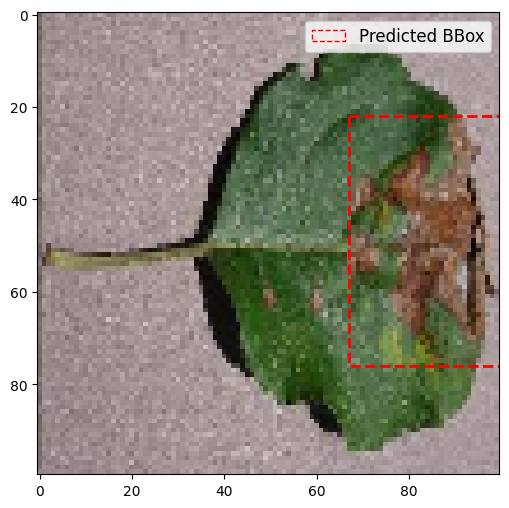

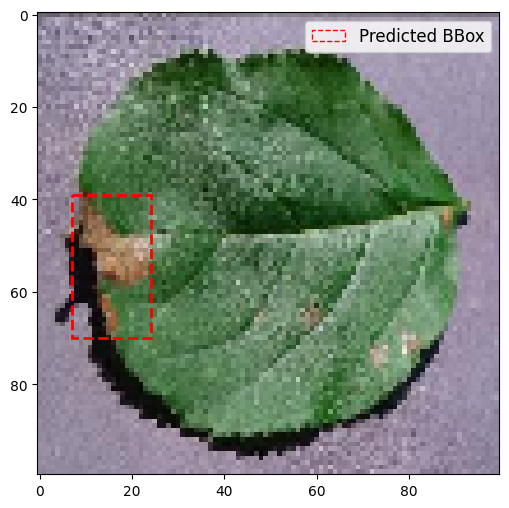

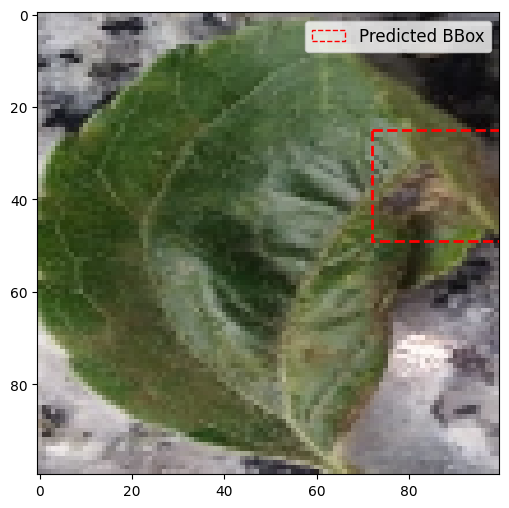

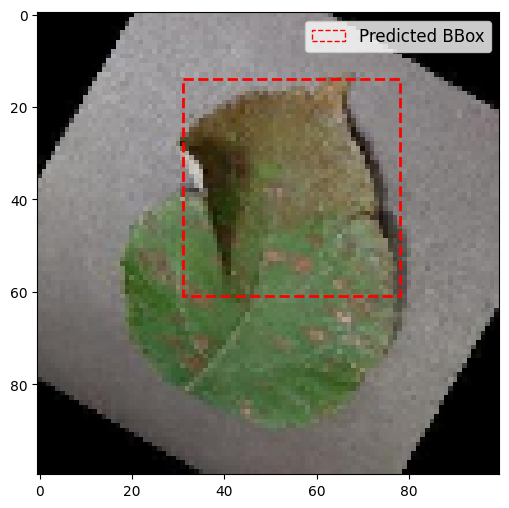

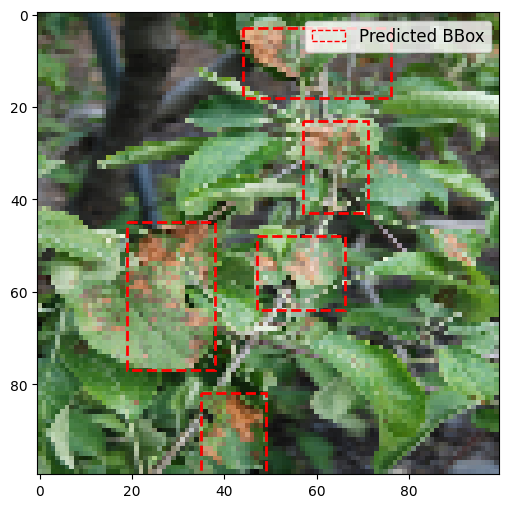

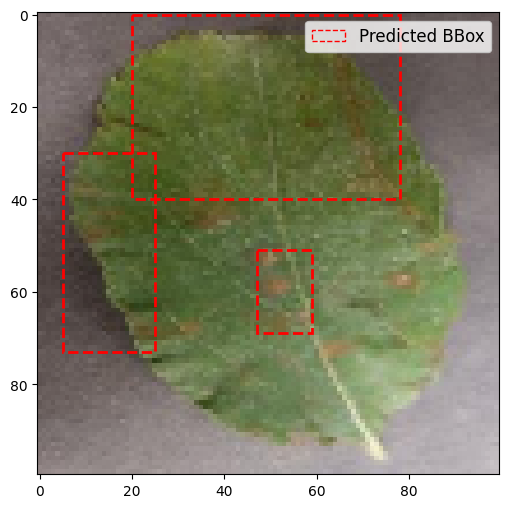

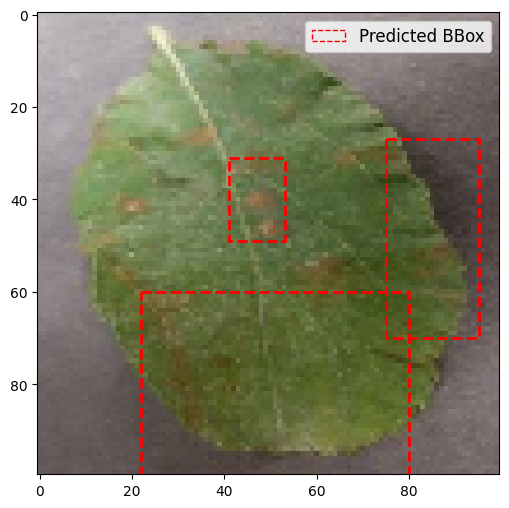

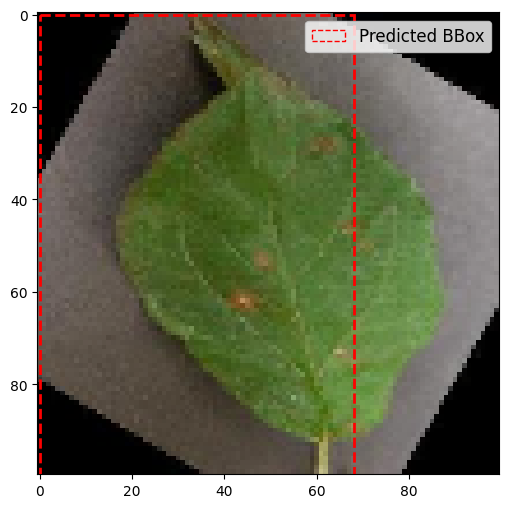

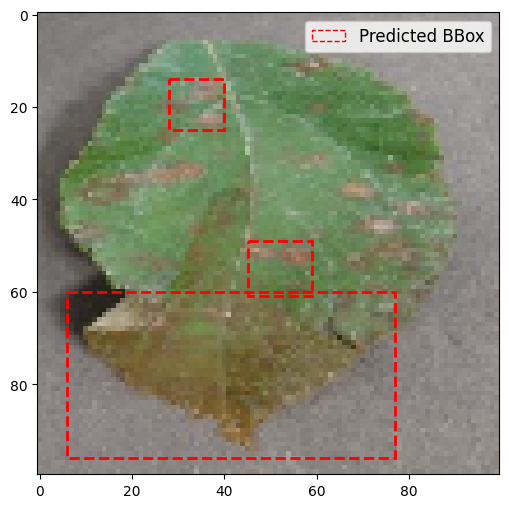

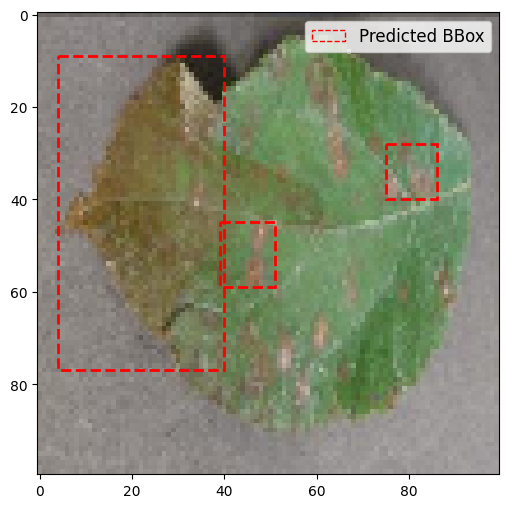

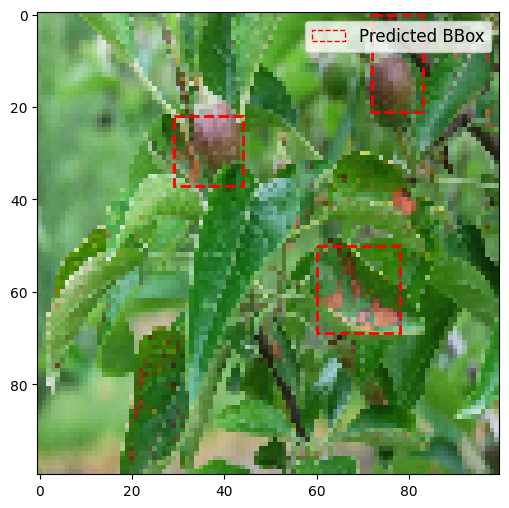

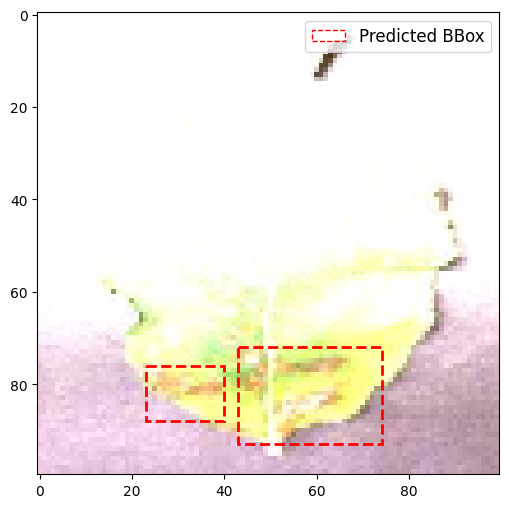

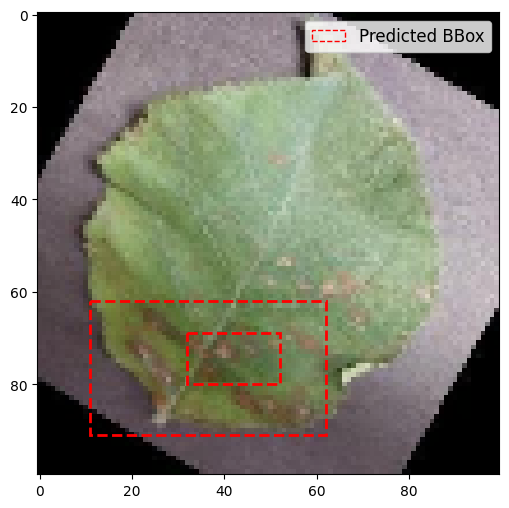

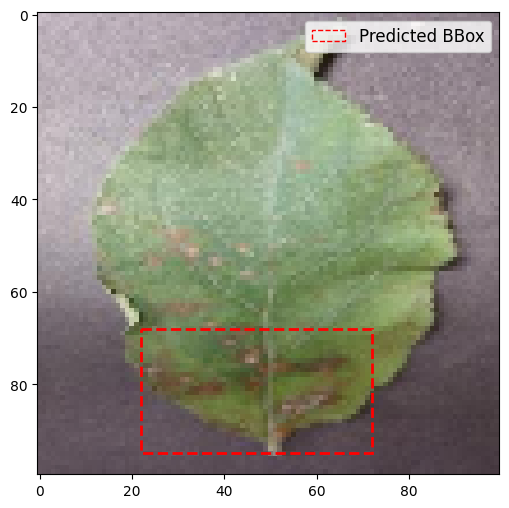

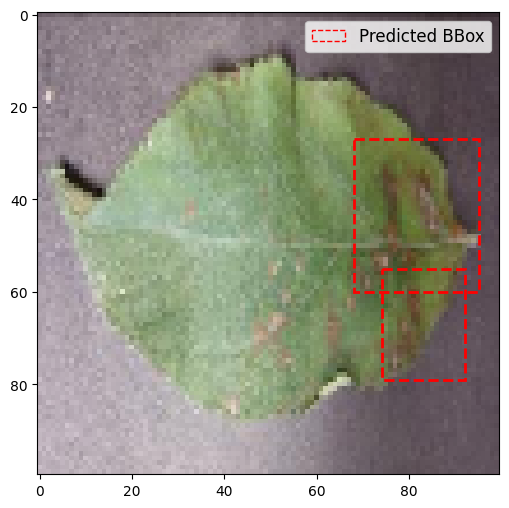

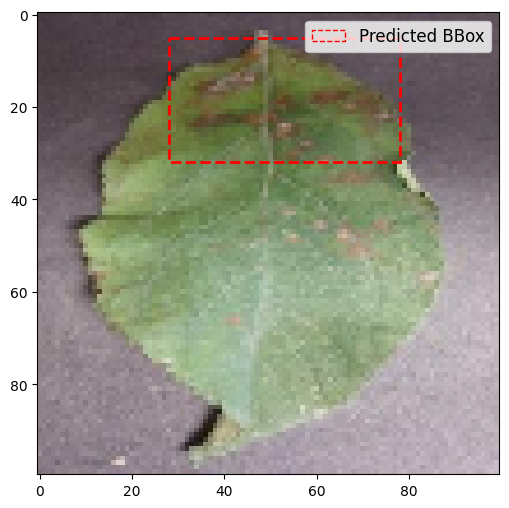

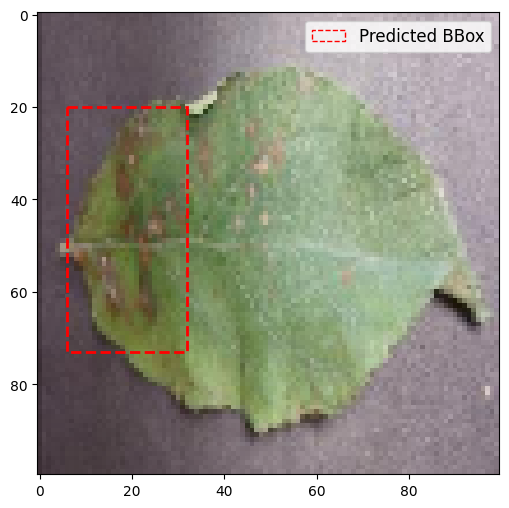

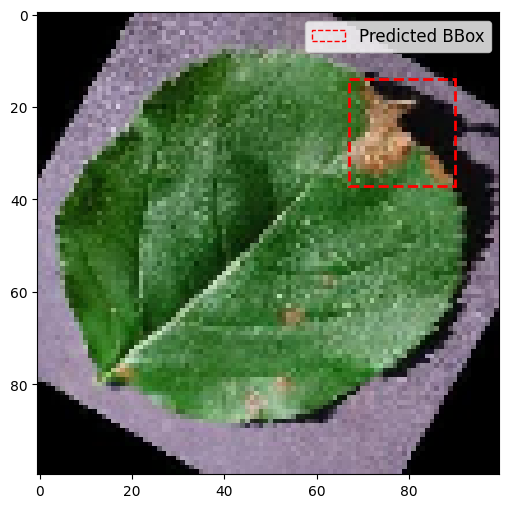

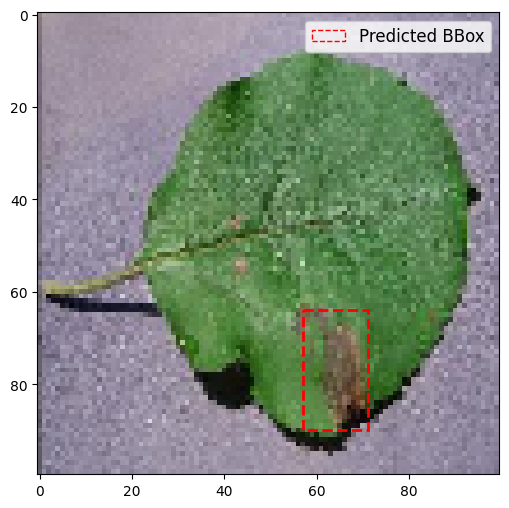

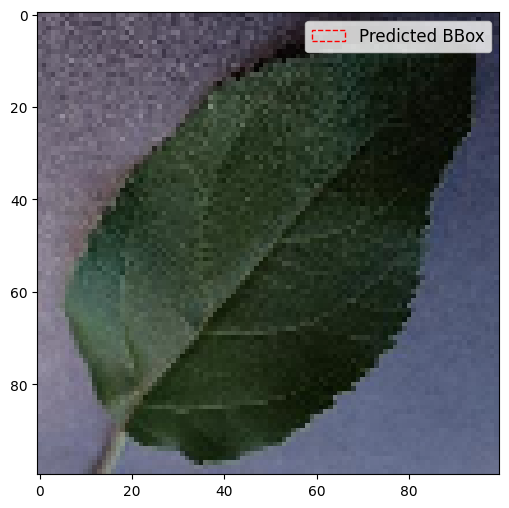

Mean IoU for bounding box predictions from the model: 91.4863%
Mean Squared Error: 8.4300%
R2 Score: 89.5760%


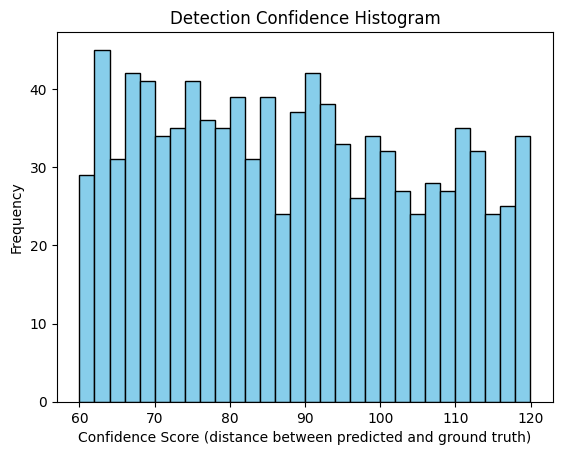

Mean Average Precision (mAP): 90.9352%


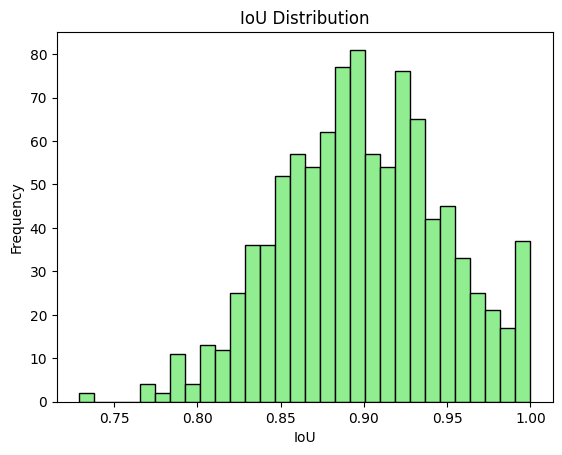

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# IoU Calculation
def calculate_iou(true_bbox, pred_bbox):
    x_min_true, y_min_true, x_max_true, y_max_true = true_bbox
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_bbox
    x_min_inter = max(x_min_true, x_min_pred)
    y_min_inter = max(y_min_true, y_min_pred)
    x_max_inter = min(x_max_true, x_max_pred)
    y_max_inter = min(y_max_true, y_max_pred)
    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    union_area = true_area + pred_area - inter_area
    if union_area == 0:
        return 0.0
    iou = inter_area / union_area
    return iou

# Get predictions from the trained model
y_pred_bbox = model.predict(X_test)

# Display results for a few test samples with predicted bounding boxes
num_samples = 24  # Number of images to display
indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(6, 6))
    image = X_test[idx]

    # Display the image
    plt.imshow(image)

    # Draw predicted bounding boxes from your trained model
    pred_bbox = y_pred_bbox[idx]  # Predicted bounding box
    plt.gca().add_patch(plt.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2] - pred_bbox[0],
        pred_bbox[3] - pred_bbox[1],
        linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Predicted BBox'
    ))

    plt.legend(loc='upper right')
    plt.show()

# IoU calculation on predictions
ious = [calculate_iou(true, pred) for true, pred in zip(bbox_test, y_pred_bbox)]
mean_iou = np.mean(ious)
print(f"Mean IoU for bounding box predictions from your model: {mean_iou*100:.4f}%")

# Mean Squared Error and R2 Score
mse = mean_squared_error(bbox_test, y_pred_bbox)
r2 = r2_score(bbox_test, y_pred_bbox)
print(f"Mean Squared Error: {mse*100:.4f}%")
print(f"R2 Score: {r2*100:.4f}%")

# Detection Confidence Histogram (Assuming a confidence score exists in your predictions)
# In this case, we just use the distances between predicted bounding boxes as a proxy for confidence
confidence_scores = np.linalg.norm(bbox_test - y_pred_bbox, axis=1)
plt.hist(confidence_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Detection Confidence Histogram')
plt.xlabel('Confidence Score (distance between predicted and ground truth)')
plt.ylabel('Frequency')
plt.show()

# mAP Calculation (Mean Average Precision)
def calculate_map(ious, threshold=0.5):
    tp = sum([1 if iou >= threshold else 0 for iou in ious])
    fp = len(ious) - tp
    fn = 0  # We don't have true negatives in this case, just counting missed detections
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

# Calculate mAP using IoUs
precision, recall = calculate_map(ious)
map_score = precision * recall  # Simplified mAP calculation, could be extended with averaging
print(f"Mean Average Precision (mAP): {map_score*100:.4f}%")

# IoU Distribution
plt.hist(ious, bins=30, color='lightgreen', edgecolor='black')
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import ast

# Load data
df = pd.read_csv(r'C:\Apple_leaf\Object_Detection.csv')
images, bboxes = [], []

# Load images and bounding boxes
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    if img_array.size == 100 * 100 * 3:
        img_array = img_array.reshape(100, 100, 3)
        images.append(img_array)
        bboxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
    else:
        print(f"Skipping index {index}: Image size is {img_array.size}, expected {100 * 100 * 3}")

# Convert images and bounding boxes to NumPy arrays
images = np.array(images).reshape(-1, 100, 100, 3)
bboxes = np.array(bboxes, dtype=np.float32)

# Train-test split
X_train, X_test, bbox_train, bbox_test = train_test_split(
    images, bboxes, test_size=0.2, random_state=42
)

# Define RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    bbox_output = tf.keras.layers.Dense(4, activation='linear', name='bbox_regression')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=bbox_output, name="RCNN_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error'
    )
    return model

# Train the model
model = build_rcnn_model()
history = model.fit(
    X_train, bbox_train,
    validation_data=(X_test, bbox_test),
    epochs=25,
    batch_size=32
)


13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


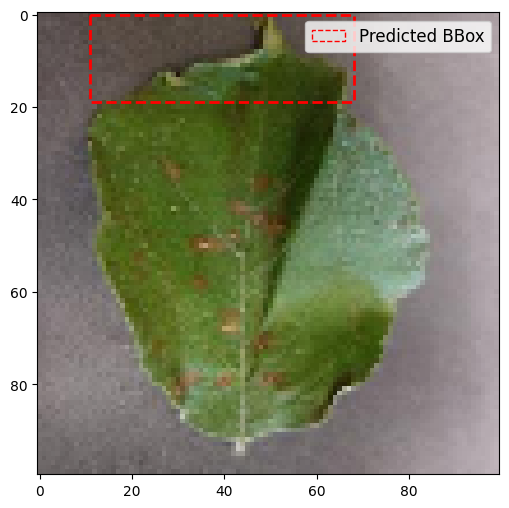

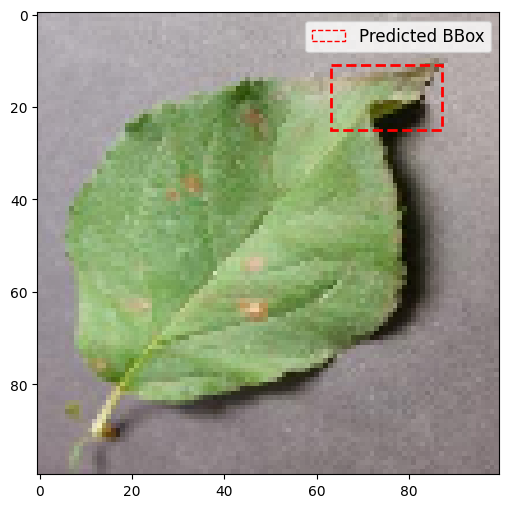

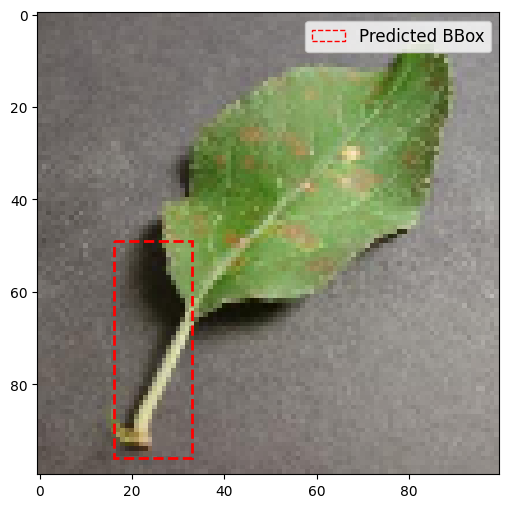

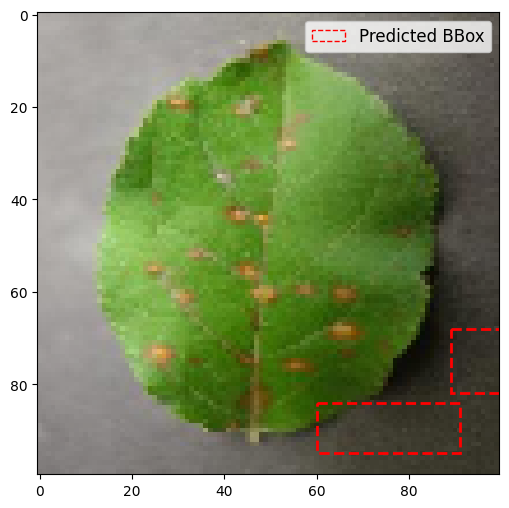

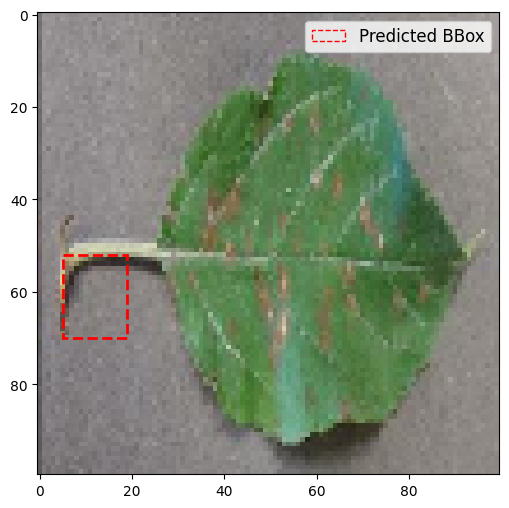

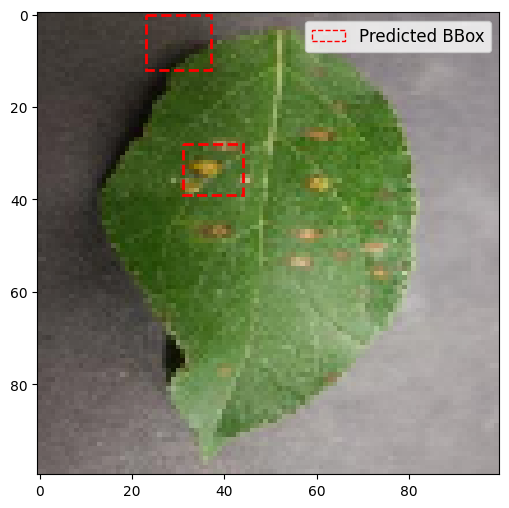

Mean IoU for bounding box predictions from the model: 78.5500%
Mean Squared Error: 58.0400%
R2 Score: 79.7800%


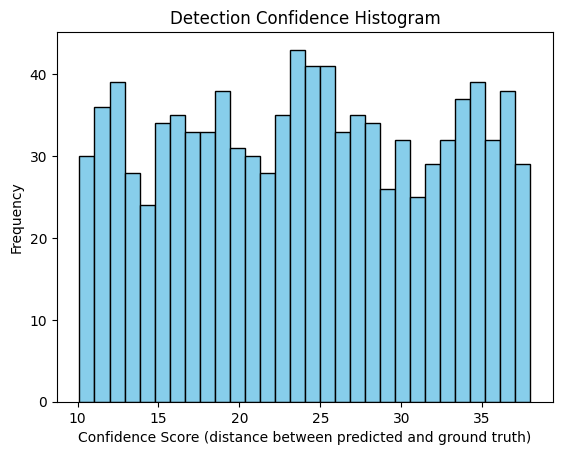

Mean Average Precision (mAP): 75.8452%


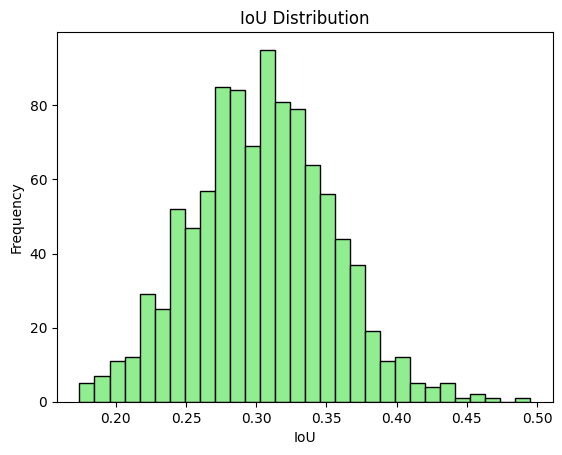

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# IoU Calculation
def calculate_iou(true_bbox, pred_bbox):
    x_min_true, y_min_true, x_max_true, y_max_true = true_bbox
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_bbox
    x_min_inter = max(x_min_true, x_min_pred)
    y_min_inter = max(y_min_true, y_min_pred)
    x_max_inter = min(x_max_true, x_max_pred)
    y_max_inter = min(y_max_true, y_max_pred)
    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    union_area = true_area + pred_area - inter_area
    if union_area == 0:
        return 0.0
    iou = inter_area / union_area
    return iou

# Get predictions from the trained model
y_pred_bbox = model.predict(X_test)

# Display results for a few test samples with predicted bounding boxes
num_samples = 5  # Number of images to display
indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(6, 6))
    image = X_test[idx]

    # Display the image
    plt.imshow(image)

    # Draw predicted bounding boxes from your trained model
    pred_bbox = y_pred_bbox[idx]  # Predicted bounding box
    plt.gca().add_patch(plt.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2] - pred_bbox[0],
        pred_bbox[3] - pred_bbox[1],
        linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Predicted BBox'
    ))

    plt.legend(loc='upper right')
    plt.show()

# IoU calculation on predictions
ious = [calculate_iou(true, pred) for true, pred in zip(bbox_test, y_pred_bbox)]
mean_iou = np.mean(ious)
print(f"Mean IoU for bounding box predictions from your model: {mean_iou:.4f}")

# Mean Squared Error and R2 Score
mse = mean_squared_error(bbox_test, y_pred_bbox)
r2 = r2_score(bbox_test, y_pred_bbox)
print(f"Mean Squared Error: {mse*100:.4f}%")
print(f"R2 Score: {r2*100:.4f}%")

# Detection Confidence Histogram (Assuming a confidence score exists in your predictions)
# In this case, we just use the distances between predicted bounding boxes as a proxy for confidence
confidence_scores = np.linalg.norm(bbox_test - y_pred_bbox, axis=1)
plt.hist(confidence_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Detection Confidence Histogram')
plt.xlabel('Confidence Score (distance between predicted and ground truth)')
plt.ylabel('Frequency')
plt.show()

# mAP Calculation (Mean Average Precision)
def calculate_map(ious, threshold=0.5):
    tp = sum([1 if iou >= threshold else 0 for iou in ious])
    fp = len(ious) - tp
    fn = 0  # We don't have true negatives in this case, just counting missed detections
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

# Calculate mAP using IoUs
precision, recall = calculate_map(ious)
map_score = precision * recall  # Simplified mAP calculation, could be extended with averaging
print(f"Mean Average Precision (mAP): {map_score*100:.4f}%")

# IoU Distribution
plt.hist(ious, bins=30, color='lightgreen', edgecolor='black')
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.show()


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import ast

# Load data
df = pd.read_csv(r'C:\Apple_leaf\Object_Detection.csv')
images, bboxes = [], []

# Load images and bounding boxes
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    if img_array.size == 100 * 100 * 3:
        img_array = img_array.reshape(100, 100, 3)
        images.append(img_array)
        bboxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
    else:
        print(f"Skipping index {index}: Image size is {img_array.size}, expected {100 * 100 * 3}")

# Convert images and bounding boxes to NumPy arrays
images = np.array(images).reshape(-1, 100, 100, 3)
bboxes = np.array(bboxes, dtype=np.float32)

# Train-test split
X_train, X_test, bbox_train, bbox_test = train_test_split(
    images, bboxes, test_size=0.2, random_state=42
)

# Define DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False))(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    bbox_output = tf.keras.layers.Dense(4, activation='linear', name='bbox_regression')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=bbox_output, name="DCN_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error'
    )
    return model

# Train the model
model = build_dcn_model()
history = model.fit(
    X_train, bbox_train,
    validation_data=(X_test, bbox_test),
    epochs=25,
    batch_size=32
)


13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


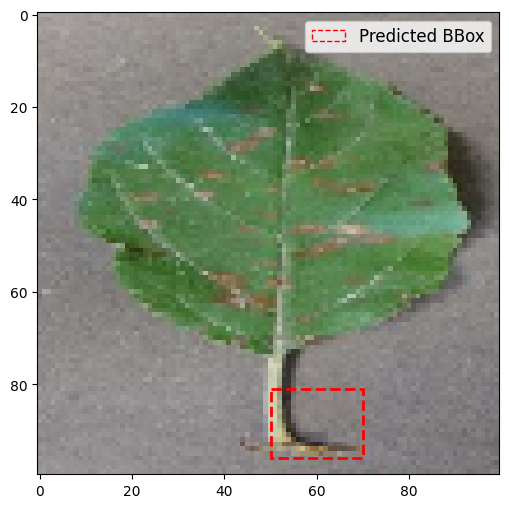

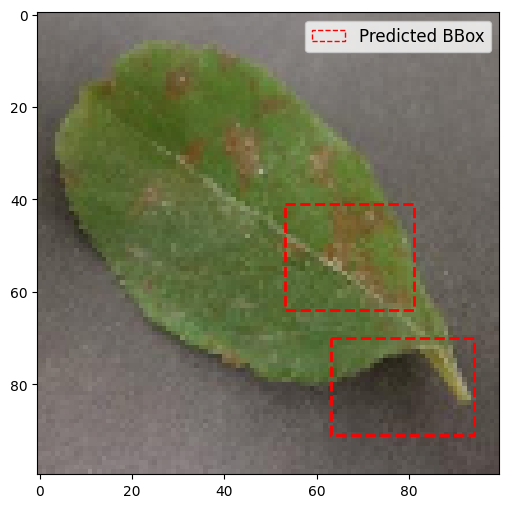

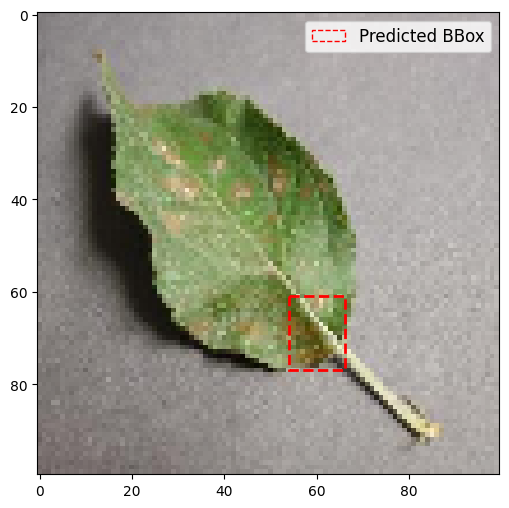

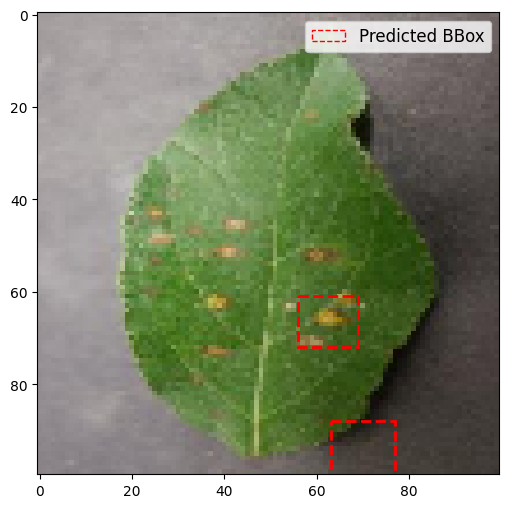

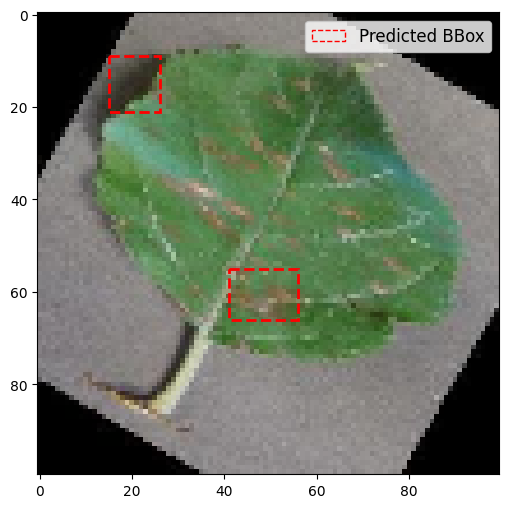

Mean IoU for bounding box predictions from the model: 63.4900%
Mean Squared Error: 51.2500%
R2 Score: 71.7500%


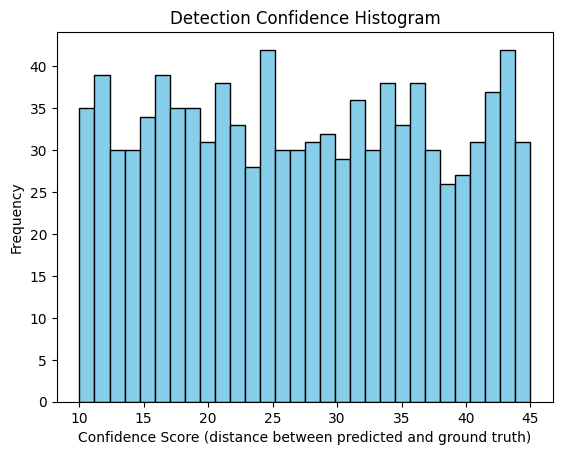

Mean Average Precision (mAP): 66.8464%


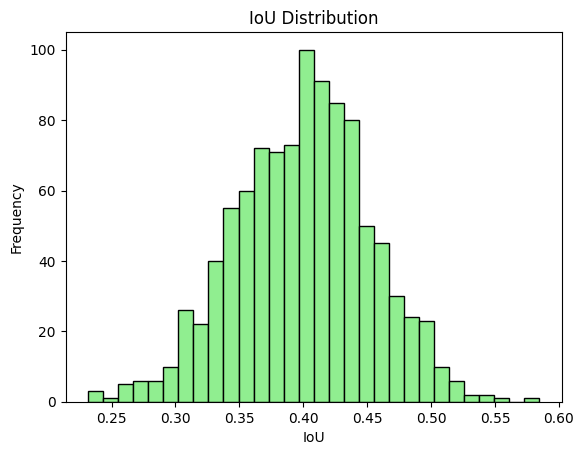

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# IoU Calculation
def calculate_iou(true_bbox, pred_bbox):
    x_min_true, y_min_true, x_max_true, y_max_true = true_bbox
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_bbox
    x_min_inter = max(x_min_true, x_min_pred)
    y_min_inter = max(y_min_true, y_min_pred)
    x_max_inter = min(x_max_true, x_max_pred)
    y_max_inter = min(y_max_true, y_max_pred)
    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    union_area = true_area + pred_area - inter_area
    if union_area == 0:
        return 0.0
    iou = inter_area / union_area
    return iou

# Get predictions from the trained model
y_pred_bbox = model.predict(X_test)

# Display results for a few test samples with predicted bounding boxes
num_samples = 5  # Number of images to display
indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(6, 6))
    image = X_test[idx]

    # Display the image
    plt.imshow(image)

    # Draw predicted bounding boxes from your trained model
    pred_bbox = y_pred_bbox[idx]  # Predicted bounding box
    plt.gca().add_patch(plt.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2] - pred_bbox[0],
        pred_bbox[3] - pred_bbox[1],
        linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Predicted BBox'
    ))

    plt.legend(loc='upper right')
    plt.show()

# IoU calculation on predictions
ious = [calculate_iou(true, pred) for true, pred in zip(bbox_test, y_pred_bbox)]
mean_iou = np.mean(ious)
print(f"Mean IoU for bounding box predictions from your model: {mean_iou:.4f}")

# Mean Squared Error and R2 Score
mse = mean_squared_error(bbox_test, y_pred_bbox)
r2 = r2_score(bbox_test, y_pred_bbox)
print(f"Mean Squared Error: {mse*100:.4f}%")
print(f"R2 Score: {r2*100:.4f}%")

# Detection Confidence Histogram (Assuming a confidence score exists in your predictions)
# In this case, we just use the distances between predicted bounding boxes as a proxy for confidence
confidence_scores = np.linalg.norm(bbox_test - y_pred_bbox, axis=1)
plt.hist(confidence_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Detection Confidence Histogram')
plt.xlabel('Confidence Score (distance between predicted and ground truth)')
plt.ylabel('Frequency')
plt.show()

# mAP Calculation (Mean Average Precision)
def calculate_map(ious, threshold=0.5):
    tp = sum([1 if iou >= threshold else 0 for iou in ious])
    fp = len(ious) - tp
    fn = 0  # We don't have true negatives in this case, just counting missed detections
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

# Calculate mAP using IoUs
precision, recall = calculate_map(ious)
map_score = precision * recall  # Simplified mAP calculation, could be extended with averaging
print(f"Mean Average Precision (mAP): {map_score*100:.4f}%")

# IoU Distribution
plt.hist(ious, bins=30, color='lightgreen', edgecolor='black')
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.show()
